# Binary Integer Programming With Python
*This notebook first appeared as a [blog](http://themodernscientist.com/posts/2013/2013-05-29-binary_integer_programming_with_python/) post on [themodernscientist](http://themodernscientist.com).  
License: [BSD](http://opensource.org/licenses/BSD-3-Clause) (C) 2013, Michelle L. Gill. Feel free to use, distribute, and modify with the above attribution.*

This notebook demonstrates how to use python to interface with two open source packages for binary integer programming, [GLPK](http://www.gnu.org/software/glpk/) and [lp_solve](http://lpsolve.sourceforge.net). These packages are demonstrated using two python libraries, [CVXOPT](http://cvxopt.org), which interacts with GLPK, and lp_solve's own python interface. An example for matching five *x,y*-coordinate pairs from two different data sets is shown for each library.
## Setup notes and module import
CVXOPT must be installed with GLPK support and lp_solve with python bindings must be installed. GLPK, lp_solve (without python interface), and CVXOPT are available via [MacPorts](http://macports.org). I have created a [GitHub repository](https://github.com/mlgill/macports-lp_solve-python) with the MacPorts configuration files necessary to install lp_solve with its python bindings. Alternatively, the python functionality for lp_solve could be installed in a separate repository with `virtualenv`. The import statements below assume that GLPK and CVXOPT have been installed as provided by MacPorts and the modified lp_solve from GitHub has been installed within MacPorts as well. Finally, numpy is required for working with arrays. Matplotlib is required only if plotting the results of the optimization is desired.

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import ConnectionPatch
from cvxopt import matrix
from cvxopt.glpk import ilp
from lp_solve.lp_solve import lp_solve
%matplotlib inline

## Create two data sets
The first data set contains five *x,y*-coordinate pairs where the first column is *x*- and the second column is *y*-data.

In [4]:
data1 = np.array([[1.5, 7.2], [2.1, 7.1], [4.9, 8.1], [3.5, 8.2], [1.6, 6.4]])
print(data1)

[[ 1.5  7.2]
 [ 2.1  7.1]
 [ 4.9  8.1]
 [ 3.5  8.2]
 [ 1.6  6.4]]


The second data set is similar to the first but has random noise added to it. The order of the points is also shuffled so the optimization solution isn't trivial.

In [5]:
np.random.seed(42)
noise = (np.random.random(data1.shape)-0.5)/5.
peakReorder = np.arange(data1.shape[0])
np.random.shuffle(peakReorder)
data2 = data1[peakReorder] + noise

Add some names for the data points and shuffle them in the same way for the second data set. This will be useful later when determining if the peaks were correctly matched.

In [6]:
data1names = np.array(['peak1', 'peak2', 'peak3', 'peak4', 'peak5'])
data2names = data1names[peakReorder]

## Calculate the distance between each pair of data points
The goal of the optimization is to minimize the sum of the distance between each set of matched points. Thus, the cartesian distance must be calculated for each point in `data1` and the set of points in `data2`. The simplest way to do this is with a distance matrix containing all peaks from `data1` along one axis and those from `data2` along the second axis.

In [7]:
xdist = data1[:, 0][:, np.newaxis] - data2[:,0]
ydist = data1[:, 1][:, np.newaxis] - data2[:,1]
dist = (xdist**2 + ydist**2)**0.5
n_data1, n_data2 = dist.shape

In the above line, `n_data1` and `n_data2` are the number of points in `data1` and `data2`, respectively.

## Setup the binary integer programming problem
In addition to calculating the distance matrix, the optimization requires setting constraints to ensure that each point in one data set is paired with at most one point in the corresponding data set. This is accomplished using the following two constraints:

$\matrix{A} \space \times \space \matrix{X} \space = \space \matrix{b}$

$\matrix{C} \space \times \space \matrix{X} \space \leq \space \matrix{d}$

where $\matrix{A}$ and $\matrix{C}$ are binary (all values are either `0` or `1`) matrices whose first dimensions are `n_data1` and `n_data2`, respectively, and both second dimensions are the product of the two data set sizes, `n_data1` $\times$ `n_data2`. $\matrix{b}$ and $\matrix{d}$ are column vectors of length `n_data1` and `n_data2`, respectively, whose value is `1` everywhere. Given these constraints, the goal of the optimization is to find a matrix $\matrix{X}$ that minimizes the target function:

$\matrix{f} \space \times \space \matrix{X}$

where $\matrix{f}$ is the distance matrix calculated above, except that it has been "flattened": converted to a column vector of length `n_data1` $\times$ `n_data2`. $\matrix{X}$ is a flattened form of the binary-valued transformation matrix, where the position of the ones in this matrix maps `data2` onto `data1`.

An in-depth discussion of integer programming theory is beyond both the scope of this post and the extent of my optimization knowledge, but I'd like to provide further explanation of how I think about the target (minimized) function and constraint equations. In the target function, $\matrix{X}$ selects the set of distances in $\matrix{f}$ that correspond to matched points so that the sum of these values can be determined and minimized. In the first constraint equation, matrix $\matrix{A}$ ensures there is only a single `1` value in each "row" of $\matrix{X}$, so each point in `data1` is paired to exactly one point in `data2`. Pretending for a moment that the inequality in the second constraint is actually an equality, this equation accomplishes the analogous goal of ensuring each point in `data2` is paired to exactly one point in `data1`. The inequality enables one of the data sets (`data2` as setup here) to have extra points that are not matched to any points in `data1`.

These matrices are setup as follows:

In [8]:
A = np.kron(np.eye(n_data1), np.ones((1, n_data2)))
b = np.ones((n_data1, 1))
C = np.tile(np.eye(n_data2), (1, n_data1))
d = np.ones((n_data2, 1))
f = dist.ravel()

## Implementation using CVXOPT and GLPK

Having setup the constraints above, the remaining steps for performing the optimization using CVXOPT are relatively simple. CVXOPT is capable of many types of optimization, thus the variable `binVars` is used to define the position of all elements in $\matrix{X}$ which are both integer and binary. (For this optimization, that is every element of $\matrix{X}$. Because $\matrix{f}$ is the same length as $\matrix{X}$ and is already defined, its length is used to determine `binVars`.) Also note that CVXOPT's integer programming function, `ilp`, does not accept numpy matrices and instead requires its own `matrix` function that is imported above. Lastly, all the functions use their own variable names, so they are listed as named arguments to eliminate confusion.

In [9]:
binVars = range(len(f)) # ilp won't accept numpy's arange even when as a set
output_cvxopt = ilp(c=matrix(f), G=matrix(C), h=matrix(d), 
                    A=matrix(A), b=matrix(b),
                    I=set(binVars), B=set(binVars))

The variable `output_cvxopt` contains several variables, one of which indicates if the optimization converged and, if it did, another variable containing $\matrix{X}$. Normally, it's good practice to check that the optimization converged, but in this case it's known to work. The transformation matrix, `X_cvxopt`, is reshaped into a two-dimensional matrix so it can easily be used to determine the order of `data2` data points that matches them with those in `data1`.

In [10]:
X_cvxopt = np.array(output_cvxopt[1]).reshape((n_data1, n_data2))
match_cvxopt = np.nonzero(X_cvxopt)[1]

### Sanity check the optimization results
It is incredibly easy to get dimensions transposed, particularly when matrices have to be flattened and reshaped. Thus, it is critical to check the results. In the above optimization, the peak labels should be identical for each point if the peaks are correctly matched.

In [11]:
print('Optimization using CVXOPT succeeded? ', 
       (data1names == data2names[match_cvxopt]).all())

Optimization using CVXOPT succeeded?  True


Another, more graphical sanity check, involves plotting the data sets on two graphs and connecting the matched pairs.

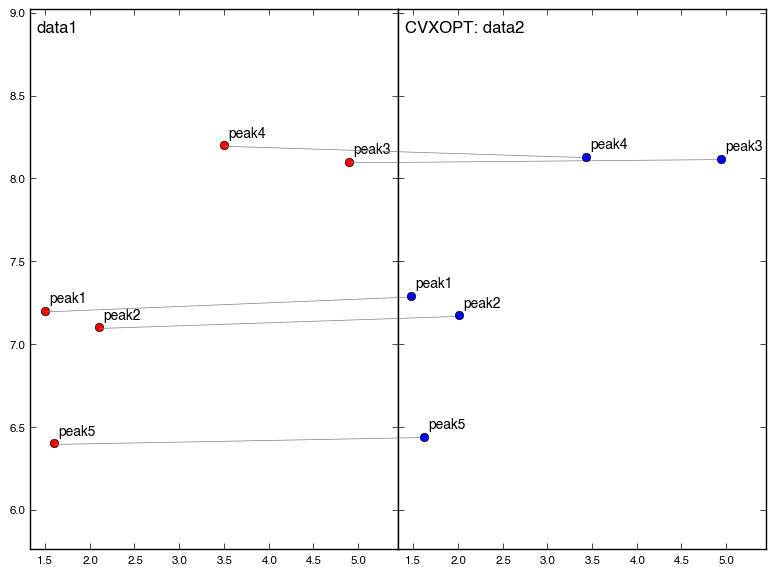

In [12]:
# Setup the figure, axes, and plot the data
fig = plt.figure()
fig.set_facecolor((1.0, 1.0, 1.0, 1.0))
plt.subplots_adjust(hspace=0.0001, wspace=0.0001,
         left=0.05, right=0.97, top=0.95, bottom=0.05)
ax1 = plt.subplot(121)
ax1.plot(data1[:,0], data1[:,1], 'ro')
ax2 = plt.subplot(122)
ax2.plot(data2[:,0], data2[:,1], 'bo')

# Make the axes limits and labels nice
datajoin = np.concatenate((data1, data2))
minLim = 0.9*np.min(datajoin, axis=0)
maxLim = 1.1*np.max(datajoin, axis=0)
ax1.set_xlim(minLim[0], maxLim[0])
ax1.set_ylim(minLim[1], maxLim[1])
ax2.set_xlim(minLim[0], maxLim[0])
ax2.set_ylim(minLim[1], maxLim[1])
ax2.set_yticklabels('')
ax1.annotate('data1', xy=(0.02,0.98), 
          xycoords='axes fraction', size='medium', va='top')
ax2.annotate('CVXOPT: data2', xy=(0.02,0.98), 
          xycoords='axes fraction', size='medium', va='top')

# Label each data point and draw a line to connect the matched pairs
offset = 0.05
for (d1,l1, d2, l2) in zip(data1, data1names, 
                           data2[match_cvxopt], data2names[match_cvxopt]):
    
    ax1.annotate(l1, xy=(d1[0]+offset,d1[1]+offset), xycoords='data', size='small')
    ax2.annotate(l2, xy=(d2[0]+offset,d2[1]+offset), xycoords='data', size='small')
    
    # The axis to which the ConnectionPatch is added to has to be `axesA`
    con = ConnectionPatch(xyA=(d2[0],d2[1]), xyB=(d1[0],d1[1]), coordsA='data', 
                coordsB='data', axesA=ax2, axesB=ax1, linewidth=0.5, color='gray')
    ax2.add_artist(con)

## Implementation using lp_solve
The `lp_solve` wrapper requires all constraint functions to be entered as a single matrix, so $\matrix{A}$ and $\matrix{C}$ must be combined and, likewise, $\matrix{b}$ and $\matrix{d}$. The relationships ($\leq$, =, and $\geq$) are determined by a vector with a negative, zero, or positive value, respectively.

In [13]:
G = np.concatenate((A, C))
h = np.concatenate((b, d))
e = np.concatenate((np.zeros((n_data1,), dtype=np.int),
                    np.ones((n_data2,), dtype=np.int)*-1))

As with CVXOPT, a set of integers, `binVars2`, is used set every value of $\matrix{X}$ to an integer. For `lp_solve`, the indexing for this set should start at `1` instead of `0`. To ensure that each of these integers is binary, a lower bound of `0` and upper bound of `1` has to be set as well.

In [14]:
binVars2 = range(1, len(f)+1)
vlb = np.zeros((len(f),), dtype=np.int)
vub = np.ones((len(f),), dtype=np.int)

**Important**: `lp_solve` maximizes the target function. To get the optimization to minimize the function, the value of $\matrix{f}$ must be negated.

In [15]:
fneg = -f

The optimization is performed and then the transformation matrix $\matrix{X}$ and matched list are calculated as with CVXOPT.

In [16]:
output_lpsolve = lp_solve(f=fneg, a=G, b=h, e=e, 
                          vlb=vlb, vub=vub, xint=binVars2)
X_lpsolve = np.array(output_lpsolve[1]).reshape((n_data1, n_data2))
match_lpsolve = np.nonzero(X_lpsolve)[1]

### Sanity check the optimization results

In [17]:
print('Optimization using lp_solve succeeded? ', 
      (data1names == data2names[match_lpsolve]).all())

Optimization using lp_solve succeeded?  True


The data could be checked graphically as well if desired.